In [1]:
import numpy as np
import typing
from matplotlib import pyplot as plt

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import time
import os
import copy
import tqdm

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# Model Parameters
img_width = 512
img_height = 512
img_channels = 3
batch_size = 16
num_classes = 11

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(512),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomErasing(),
        
    ]),
    'val': transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'output3'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
%matplotlib notebook
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    print(device)
    model.to(device)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm.tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    #outputs = model(inputs)
                    outputs = model(inputs)
                    preds = torch.argmax(outputs, dim=-1, keepdim=False)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), './resnet18_3.wts')
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
def visualize_model(model, test_loader, device):
    #was_training = model.training
    #model.eval()
    images_so_far = 0
    final_true = torch.tensor(())
    final_preds = torch.tensor(())
    correct = 0
    model.to(device)
    with torch.no_grad():
        for i, (inputs, labels) in tqdm.tqdm(enumerate(test_loader)):
#             if images_so_far >= 1000:
#                 print("break")
#                 break
            inputs = inputs.to(device)
            
            labels = labels.to(device)
            outputs = model(inputs)
            
            preds = torch.argmax(outputs, dim=-1, keepdim=False)
            assert preds.shape[0] == labels.shape[0], "wtf"
            
            images_so_far += inputs.shape[0]
            
            correct += (preds == labels).float().sum()
            
            final_true = torch.hstack((final_true, labels.cpu().flatten()))
            final_preds = torch.hstack((final_preds, preds.cpu().flatten()))
    
    return final_true, final_preds, (correct / images_so_far)

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes)

#model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

In [8]:
#model = model_ft.load_state_dict(torch.load('./resnet18_2.wts', map_location='cpu'))
model_ft.load_state_dict(torch.load('./resnet18_epoch_5.wts'))

<All keys matched successfully>

In [10]:
image_datasets_test = datasets.ImageFolder(
    'output3/test',
    transforms.Compose([
        transforms.Resize(512),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
)
dataloaders_test = torch.utils.data.DataLoader(image_datasets_test, shuffle=True, batch_size=32)

In [11]:
true, pred, acc = visualize_model(model_ft, dataloaders_test, device)
print("accuracy:", acc)

5751it [22:51,  4.19it/s]

accuracy: tensor(0.9521, device='cuda:0')


In [12]:
accuracy_score(true.numpy(), pred.numpy())
# print(true.shape, pred.shape)

0.9520991599013183

<IPython.core.display.Javascript object>


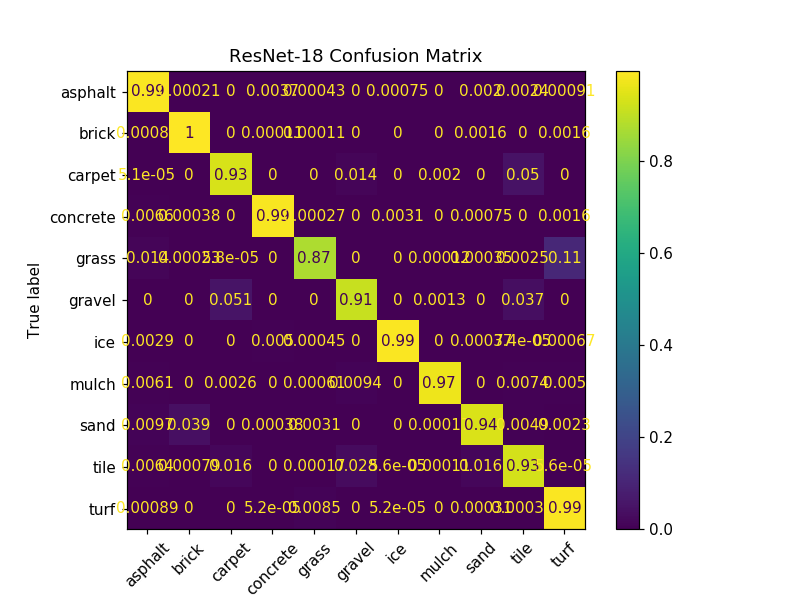

Text(0.5, 1.0, 'ResNet-18 Confusion Matrix')

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib notebook
cm = confusion_matrix(true, pred, normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmd.plot(xticks_rotation=45)
plt.title('ResNet-18 Confusion Matrix')

In [15]:
inputs, labels = next(iter(dataloaders_test))

In [20]:
output = model_ft(inputs.to(device))

<IPython.core.display.Javascript object>


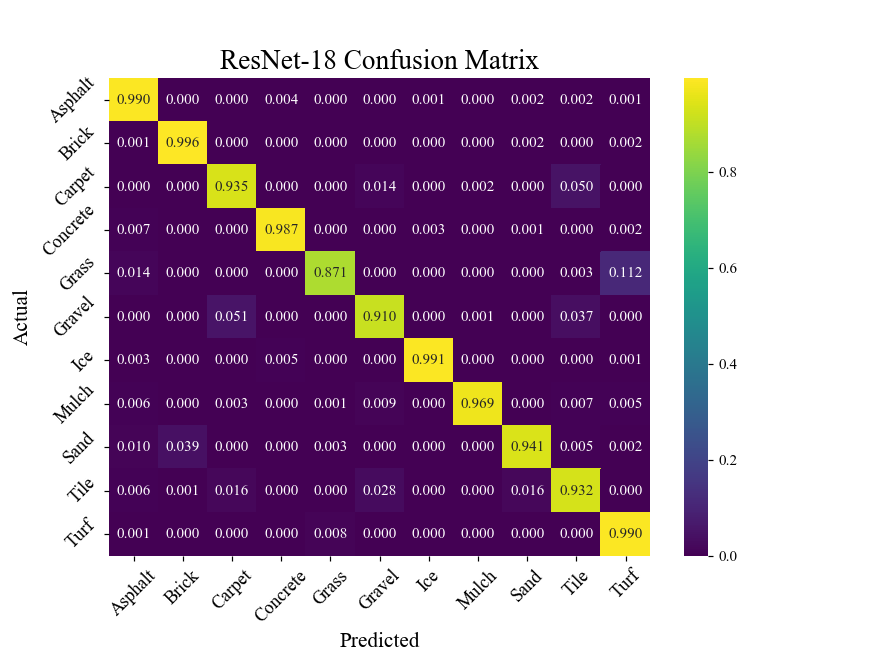

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names_cap = list(map(lambda x: x.capitalize(), class_names))
plt.rcParams["font.family"] = "Times New Roman"
cm = confusion_matrix(true, pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cmn, annot=True, fmt='.3f', xticklabels=class_names_cap, yticklabels=class_names_cap, cmap="viridis")
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.xticks(rotation = 45, fontsize=12)
plt.yticks(rotation=45, fontsize=12) 
plt.title('ResNet-18 Confusion Matrix', fontsize=18)
plt.gcf().subplots_adjust(bottom=0.15)
plt.show(block=False)

In [52]:
from sklearn.metrics import f1_score
f1_score(true, pred, average='macro')

0.9538776425905091

In [54]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  